In [ ]:
# With mask
# single line input
# and "good music files"

In [74]:
from music21 import *
import numpy as np
import glob
import math
import os
import random
from cntk import Trainer, Axis
from cntk.learner import adam_sgd, momentum_sgd, momentum_as_time_constant_schedule, learning_rate_schedule, UnitType
from cntk.ops import input_variable, classification_error, squared_error
from cntk.persist import load_model, save_model
from cntk.blocks import LSTM, Stabilizer
from cntk.layers import Recurrence, Dense, Dropout, BatchNormalization
from cntk.utils import get_train_eval_criterion, get_train_loss
from cntk.device import set_default_device, gpu

path = "2KPtestSongs"

In [77]:
lowerBound = 24 # = [python] index 0 ([R] 1. possision)
upperBound = 102 # = first index out of bound => len =78
nNotes = upperBound-lowerBound
inNotesDim=nNotes*2+4+12
outNotesDim = nNotes*2
hidden_dim = 512#256#nNotes
num_layers = 3


batch_len = 16*8 # length of each sequence

def loadPieces(midiFiles):
    pieces = {}
    totalLength= len(midiFiles)
    tempo=[0]*totalLength
    fnameNumber=0
    for fname in midiFiles:
        fnameNumber+=1
        if fname[-4:] not in ('.mid','.MID'):
            continue
        isNotBackSlash=1
        bIndex=0
        while(isNotBackSlash):
            bIndex-=1
            if fname[bIndex]=='\\':
                bIndex+=1
                isNotBackSlash=False
        name = fname[bIndex:-4]
        print("Loading",name,"...",fnameNumber,'/',totalLength)
        outMatrix, tempo[fnameNumber-1] = midi2MusicMinMatrix(fname)
        if outMatrix==0 or len(outMatrix) < batch_len:
            tempo[fnameNumber-1]=0
            print("     Loaded", name,'failed')
            continue
        else:
            print('Song length = '+str(len(outMatrix)))
            print("     Loaded", name,'done')
        pieces[name] = outMatrix
    return(pieces,tempo)



def midi2MusicMinMatrix(parseLink):
    midiFile = converter.parse(parseLink)
    try:
        tempo = 60*midiFile.flat.notes[0].duration.quarterLength/(midiFile.flat.notes[0].seconds)
    except:
        tempo = 0
    #if (midiFile.flat.getTimeSignatures().timeSignature.numerator not in (2,4)) or (midiFile.flat.getTimeSignatures().timeSignature.denominator not in (2,4)):
    #	print('     Track: is not 4/4 or similar')
    #	return(0)  
    # ? not in (2,4)
    if (midiFile.flat.getTimeSignatures().timeSignature.numerator not in (2,4)) or (midiFile.flat.getTimeSignatures().timeSignature.denominator not in (2,4)):
        print('     Track: is not 4/4')
        printing = '     Track is '+str(midiFile.flat.getTimeSignatures().timeSignature.numerator)+' / ' + str(midiFile.flat.getTimeSignatures().timeSignature.denominator)
        print(printing)
        return(0,0)
    midiPartLen=len(midiFile)
    maxTime = midiFile.highestTime
    outMatrix = [[[0,0] for tang in range(upperBound-lowerBound)]+time2Beat(lenTimes16)+[[0]*12]+[[lenTimes16/4]] for lenTimes16 in range(math.ceil(maxTime*4+2))]
    # outMatrix = [[[0,0] for tang in range(upperBound-lowerBound)]+[[lenTimes16/4]] for lenTimes16 in range(math.ceil(maxTime*4+2))]
    # outMatrix = [[[0,0] for tang in range(upperBound-lowerBound)]+[lenTimes16/4] for lenTimes16 in range(math.ceil(maxTime*4+2))]
    for t in range(midiPartLen):
        try:
            instrument=midiFile[t].getInstrument(returnDefault=False).instrumentName
        except: 
            instrument='Piano'
        #if not instrument:
        #	instrument='Piano'
        #if instrument!='Piano':
        #	print('          Part',t,'/',midiPartLen-1,' dropped, instrument was not piano')
        #	continue			
        notes=midiFile[t].flat.notes
        for i in range(0,len(notes)):
            if not notes[i].isChord:
                if (notes[i].pitch.midi<lowerBound) or (notes[i].pitch.midi>=upperBound):
                    continue
                timeIndex=round(notes[i].offset*4)+1
                notePitch=notes[i].pitch.midi-lowerBound
                outMatrix[timeIndex][notePitch]=[1,1]
                for holdLen in range(1,round(notes[i].duration.quarterLength*4)):
                    outMatrix[timeIndex+holdLen][notePitch][1]=1
            else:
                timeIndex=round(notes[i].offset*4)+1
                duration=round(notes[i].duration.quarterLength*4)+1
                for j in range(len(notes[i])):
                    if (notes[i][j].pitch.midi<lowerBound) or (notes[i][j].pitch.midi>=upperBound):
                        continue
                    #timeIndex=round(notes[i][j].offset*4)+1
                    notePitch=notes[i][j].pitch.midi-lowerBound
                    outMatrix[timeIndex][notePitch]=[1,1]
                    for holdLen in range(1,duration):
                        outMatrix[timeIndex+holdLen][notePitch][1]=1
        for iTime in range(len(outMatrix)):
            for inote in range(78):
                outMatrix[iTime][-2][inote%12]+=1/4*outMatrix[iTime][inote][1]
            outMatrix[iTime][-2]=[min(outMatrix[iTime][-2][k],1) for k in range(12)]
    return(outMatrix,tempo)

def time2Beat(time):
    beat=[[math.floor((time%16)/8),math.floor((time%8)/4),math.floor((time%4)/2),time%2]]
    return(beat)

def MusicMinMatrix2midi(MusicMinMatrixPart,S,bpm=100):
    #S = stream.Score()
    nTime=len(MusicMinMatrixPart)
    S.insert(0,tempo.MetronomeMark(number=bpm))
    p1 = stream.Part()
    p1.id = 'part1'
    nCons=0
    thisIndex=0
    mLen = len(MusicMinMatrixPart[0])
    for j in range(78):
        for i in range(nTime):
            if (nCons!=0) and (MusicMinMatrixPart[i][j] in ([0,0],[1,1])):
                n.duration.quarterLength = 0.25*nCons
                p1.insert(MusicMinMatrixPart[thisIndex][mLen-1][0],n)
                nCons=0
            if MusicMinMatrixPart[i][j]==[1,1]:
                n = note.Note()
                n.midi = lowerBound+j
                thisIndex = i
                nCons+=1
            elif (MusicMinMatrixPart[i][j]==[0,1]) and (nCons!=0):
                nCons+=1
        if (nCons != 0):
            n.duration.quarterLength = 0.25*nCons
            p1.insert(MusicMinMatrixPart[thisIndex][mLen-1][0],n)
            nCons=0
    S.insert(0,p1)
    
    
def Piece2Data(Pieces):
    tempData = sum(list(Pieces.values()),[])
    data=[sum(timePart,[]) for timePart in tempData]
    return(np.array(data,dtype=np.float32))

def pieces2Arr(Pieces):
    ArrPieces={}
    songs=list(Pieces.keys())
    for i in range(len(songs)):
        BrakComb=[sum(timePart,[]) for timePart in Pieces[songs[i]]]
        ArrPieces[songs[i]] =np.array(BrakComb,dtype=np.float32)
    return(ArrPieces)
    

def get_data(p, minibatch_size, data):
    x = data[p:p+minibatch_size,0:172]
    y = data[p+1:p+minibatch_size+1,0:156]
    #xsum=x.sum(axis=1, keepdims=True)
    return([x],[y])

def data2MusicMatric(data):
    timeIndex=0
    MusicMatrix=[0]*len(data)
    MusicMatrixRow=[0]*(upperBound-lowerBound)
    for i in range(len(data)):
        for j in range(upperBound-lowerBound):
            MusicMatrixRow[j] = [int(data[i,j*2]),int(data[i,j*2+1])]
        MusicMatrix[i] = MusicMatrixRow+[[timeIndex]]
        timeIndex+=0.25
    return(MusicMatrix)



#def Output2data(p):
#    p=p[0][0]
#    return((p>np.random.random_sample((1, len(p))))*1)
    # return(list((p>p.mean()+threshold)*1))
def Output2data(p,outlag):
    p=p[0][0]
    out=(p>np.random.random_sample((1, len(p))))*1
    for i in range(78):
        if outlag[i*2+1]==0 and out[0][i*2]==0:
            out[0][i*2+1]=0
        elif out[0][i*2]==1:
            out[0][i*2+1]=1
    return(out)

def numNotes(notes):
    for inote in range(78):
        notes[160+inote%12]+=1/4*notes[inote*2+1]
    notes[160:172]=np.minimum.reduce([notes[160:172],[1]*12])#[min(notes[k],1) for k in range(159,172)]
    return(notes[160:172])
    
def sample(z,prime_data=np.array([[0]*((upperBound-lowerBound)*2+4+12)],dtype=np.float32),length=300):#,threshold=1.11):
    output=np.zeros((length, 173), dtype=np.float32)
    output[:,172]=[l for l in range(length)]
    p=0
    outlag=[0]*156
    for l in range(length):
        output[l,156:160]=time2Beat(l)[0]
    if len(prime_data[0])!=172:
        prime_data[:,0:172]
    randomNumb=np.random.choice(range(78))
    if len(prime_data)==1: 
        prime_data[0,randomNumb*2] = 1
        prime_data[0,randomNumb*2+1] = 1
        prime_data[0,160:172]=numNotes(prime_data[0,:])
    for i in range(len(prime_data)):
        x=prime_data[i]
        inputen=[np.array([x],dtype=np.float32)]
        # inputen=[np.array([data],dtype=np.float32)]
        # inputen=[np.array([x/np.maximum(x.sum(),1)],dtype=np.float32)]
        if i==0:
            arguments=(inputen,[True])
        else:
            p = z.eval(arguments)
            arguments=(inputen,[False])
        outlag=inputen[0][0][0:156]
    #x=prime_data[len(prime_data)-1]
    for i in range(length):
        p = z.eval(arguments)        
        output[i,0:156] = Output2data(p,outlag)# ,threshold=threshold)
        outlag = output[i,0:156]
        output[i,160:172]=numNotes(output[i,:])
        x=output[i,0:172]
        inputen=[np.array([x],dtype=np.float32)]
        # inputen=[np.array([x/np.maximum(x.sum(),1)],dtype=np.float32)]
        arguments=(inputen,[False])
    return(output)#return([list(testout[i]) for i in range(300)])
    
# prime_data=data[5:20,:]
#def sample(z,prime_data=np.array([[0]*((upperBound-lowerBound)*2+4+12)],dtype=np.float32),length=300):#,threshold=1.11):
#    output=np.zeros((length, 173), dtype=np.float32)
#    output[:,172]=[l for l in range(length)]
#    for l in range(length):
#        output[l,156:160]=time2Beat(l)[0]
#    if len(prime_data[0])!=172:
#        prime_data[:,0:172]
#    randomNumb=np.random.choice(range(78))
#    if len(prime_data)==1: 
#        prime_data[0,randomNumb*2] = 1
#        prime_data[0,randomNumb*2+1] = 1
#        prime_data[0,160:172]=numNotes(prime_data[0,:])
#    for i in range(len(prime_data)):
#        x=prime_data[i]
#        inputen=[np.array([x],dtype=np.float32)]
#        # inputen=[np.array([data],dtype=np.float32)]
#        # inputen=[np.array([x/np.maximum(x.sum(),1)],dtype=np.float32)]
#        if i==0:
#            arguments=(inputen,[True])
#        else:
#            p = z.eval(arguments)
#            arguments=(inputen,[False])
#    #x=prime_data[len(prime_data)-1]
#    for i in range(length):
#        p = z.eval(arguments)        
#        output[i,0:156]=Output2data(p)# ,threshold=threshold)
#        output[i,160:172]=numNotes(output[i,:])
#        # print(output[i,160:172])
#        x=output[i,0:172]
#        inputen=[np.array([x],dtype=np.float32)]
#        # inputen=[np.array([x/np.maximum(x.sum(),1)],dtype=np.float32)]
#        arguments=(inputen,[False])
#    return(output)#return([list(testout[i]) for i in range(300)])



In [79]:
midiFiles = glob.glob(path + '/*.mid')
Pieces,tempo = loadPieces(midiFiles)
# data = Piece2Data(Pieces)
# data=np.load('dataNpArray.npy')
# ArrPieces = np.load('ArrPieces.npy')

Loading all_my_heart_pno ... 1 / 78
Song length = 210
     Loaded all_my_heart_pno done
Loading amid_the_silencepno ... 2 / 78
     Loaded amid_the_silencepno failed
Loading angelspno ... 3 / 78
Song length = 354
     Loaded angelspno done
Loading angels_v2_pno ... 4 / 78
Song length = 338
     Loaded angels_v2_pno done
Loading as-with-gladness-men-of-old ... 5 / 78
Song length = 386
     Loaded as-with-gladness-men-of-old done
Loading away-in-a-manger ... 6 / 78
     Track: is not 4/4
     Track is 1 / 4
     Loaded away-in-a-manger failed
Loading bleak_midwinter_pno ... 7 / 78
Song length = 274
     Loaded bleak_midwinter_pno done
Loading carol-of-the-bells ... 8 / 78
     Track: is not 4/4
     Track is 3 / 4
     Loaded carol-of-the-bells failed
Loading carol_of_the_bells ... 9 / 78
Song length = 397
     Loaded carol_of_the_bells done
Loading Christmas_Carols_-_12_Days_Of_Christmas ... 10 / 78
Song length = 500
     Loaded Christmas_Carols_-_12_Days_Of_Christmas done
Loading Chris

In [80]:
ArrPieces = pieces2Arr(Pieces)
print(len(Pieces))

54


In [82]:
tlen= sum(np.array(tempo)!=0)
print(tlen)
tempAv=sum(tempo)/tlen
print(tempAv)

53
109.557358491


In [8]:
songs=list(Pieces.keys())
print(len(songs))
#ArrPieces[songs[1]][50]
for i in range(len(songs)):
    print(i)
    print(len(ArrPieces[songs[i]]))

54
0
258
1
370
2
382
3
898
4
642
5
648
6
270
7
154
8
376
9
1074
10
274
11
318
12
270
13
154
14
514
15
202
16
397
17
210
18
274
19
193
20
386
21
622
22
642
23
414
24
270
25
142
26
1027
27
174
28
510
29
500
30
654
31
310
32
158
33
130
34
306
35
520
36
386
37
1320
38
514
39
194
40
322
41
967
42
372
43
366
44
514
45
338
46
334
47
604
48
354
49
386
50
514
51
520
52
545
53
328


In [83]:
def train_mm(Pieces):
    songs=list(Pieces.keys())
    #songs=list(Pieces.keys())
    # create the stabilizer function from blocks
    stabilize = Stabilizer()
    #data = Piece2Data(Pieces)
    #data_size=len(data)

    # Source and target inputs to the model
    batch_axis = Axis.default_batch_axis()
    input_seq_axis = Axis('inputAxis')

    input_dynamic_axes = [batch_axis, input_seq_axis]
    raw_input = input_variable(shape=(inNotesDim), dynamic_axes=input_dynamic_axes)
    raw_labels = input_variable(shape=(outNotesDim), dynamic_axes=input_dynamic_axes)

    input_sequence = raw_input
    label_sequence = raw_labels

    # LSTM
    encoder_output = stabilize(input_sequence)
    for i in range(0, num_layers):
        encoder_output = Recurrence(LSTM(hidden_dim, enable_self_stabilization=True)) (encoder_output.output)
        #encoder_output = BatchNormalization() (encoder_output.output)
        # encoder_output = Dropout(0.05) (encoder_output.output)

    # get output of the LSTM
    states = encoder_output.output

    # dense layer    
    z = Dense(outNotesDim)(Dense(hidden_dim)(Dense(hidden_dim) (states)))
    
    import cntk.ops 
    # ce = binary_cross_entropy(z, label_sequence)
    # ce = cntk.ops.squared_error(z,label_sequence)
    # ce = times_transpose(label_sequence,log(z)) 
    # ce = cross_entropy_with_softmax(z, label_sequence)
    # ce = times_transpose(label_sequence,log(z))
    ce = squared_error(z,label_sequence)
    # errs = squared_error(z,label_sequence)
    errs = squared_error(z,label_sequence)#*len(label_sequence)
    #errs = classification_error(z, label_sequence)

    # Instantiate the trainer object to drive the model training
    lr_per_sample = learning_rate_schedule(0.0005, UnitType.sample)
    momentum_time_constant = momentum_as_time_constant_schedule(1100)
    clipping_threshold_per_sample = 5.0
    gradient_clipping_with_truncation = True
    learner = adam_sgd(z.parameters, lr_per_sample, momentum_time_constant, 
                           gradient_clipping_threshold_per_sample=clipping_threshold_per_sample,
                           gradient_clipping_with_truncation=gradient_clipping_with_truncation)
    trainer = Trainer(z, ce, errs, learner)
    
    minibatch_size = 128 
    loopsPrPrint = 5
    #training_progress_output_freq = 100
    #sample_freq = 20
    epochs = 300
    #minibatches_per_epoch = int((data_size / minibatch_size))
    #minibatches = epochs * minibatches_per_epoch
    
    e = 0
    p = 0
    #pnew = 0
    
    iSong=[iSong for iSong in range(len(songs))]
    songEnd=False
    songLen=0
    printCounter=0
    trainLossVec=[0]*epochs
    for i in range(epochs):
        trainLoss=0
        trainEval=0
        totInter=0
        e += 1
        print('---------------------------------------------------------------')
        print(str(e)+'/'+str(epochs))
        shouldPrint=True
        random.shuffle(iSong)
        for j in iSong:
            # print('Song nr ='+str(j))
            p = 0
            #pnew = 0
            jSong=Pieces[songs[j]]
            songLen=len(jSong)
            while not songEnd:
                # get the data            
                features, labels = get_data(p, minibatch_size, jSong)
                #print('P = '+str(p))
                #print('Seng Length = '+str(songLen))
                # Specify the mapping of input variables in the model to actual minibatch data to be trained with
                # If it's the start of the data, we specify that we are looking at a new sequence (True)
                mask = [False] 
                if p == 0:
                    mask = [True]
                #print('Mask = '+str(mask))
                arguments = ({raw_input : features, raw_labels : labels}, mask)
                trainer.train_minibatch(arguments)
                p=p+minibatch_size
                if songLen<=(p+minibatch_size+1):
                    songEnd=True
                #if shouldPrint==True: # or printCounter%loopsPrPrint==0:
                #    print("Epochs: {}, Train Loss: {}, Train Evaluation Criterion: {}".format(i,
                #        get_train_loss(trainer), get_train_eval_criterion(trainer)))
                #    shouldPrint=False
                trainLoss+=get_train_loss(trainer)
                trainEval+=get_train_eval_criterion(trainer)
                totInter+=1
            songEnd=False
            printCounter+=1
            if printCounter%10==0:
                print("Each 10th songs: {}, Train Loss: {}, Train Evaluation Criterion: {}".format(i,
                            get_train_loss(trainer), get_train_eval_criterion(trainer)))
        print("Epochs: {}, Train Loss: {}, Train Evaluation Criterion: {}".format(i,
                        trainLoss/totInter, trainEval/totInter))
        trainLossVec[i]=trainLoss/totInter
        model_filename = "models/0512composer_epoch%e.dnn" %e
        save_model(z, model_filename)
        
    return(z,trainLossVec)

In [84]:
z, trainLossVec = train_mm(ArrPieces)

---------------------------------------------------------------
1/300
Each 10th songs: 0, Train Loss: 3.616788387298584, Train Evaluation Criterion: 3.616788387298584
Each 10th songs: 0, Train Loss: 2.774275302886963, Train Evaluation Criterion: 2.774275302886963
Each 10th songs: 0, Train Loss: 3.9944405555725098, Train Evaluation Criterion: 3.9944405555725098
Each 10th songs: 0, Train Loss: 3.173851728439331, Train Evaluation Criterion: 3.173851728439331
Each 10th songs: 0, Train Loss: 3.29584002494812, Train Evaluation Criterion: 3.29584002494812
Epochs: 0, Train Loss: 3.9796100356362083, Train Evaluation Criterion: 3.9796100356362083
---------------------------------------------------------------
2/300
Each 10th songs: 1, Train Loss: 3.9254696369171143, Train Evaluation Criterion: 3.9254696369171143
Each 10th songs: 1, Train Loss: 3.7924931049346924, Train Evaluation Criterion: 3.7924931049346924
Each 10th songs: 1, Train Loss: 3.17564058303833, Train Evaluation Criterion: 3.1756405

In [68]:
#prime_data=np.array([[0]*((upperBound-lowerBound)*2)],dtype=np.float32)
#print(prime_data)
#len(prime_data[0])
#print(len(prime_data))
#data[0]
#data[1:3]
testout=0
testout=sample(z,prime_data=np.array([[0]*((upperBound-lowerBound)*2+4+12)],dtype=np.float32),length=1000) #,threshold=5)
musicM=data2MusicMatric(testout)
S = stream.Score()
MusicMinMatrix2midi(musicM,S,tempAv)#100)
#sp=midi.realtime.StreamPlayer(S)
#sp.play()

In [69]:
S.write('midi', 'MLmusicOut/Test300_3.mid') 

'MLmusicOut/Test300_3.mid'

In [57]:
model_filename = "models/deepjingling-composer_epoch300Done.dnn"
save_model(z, model_filename)

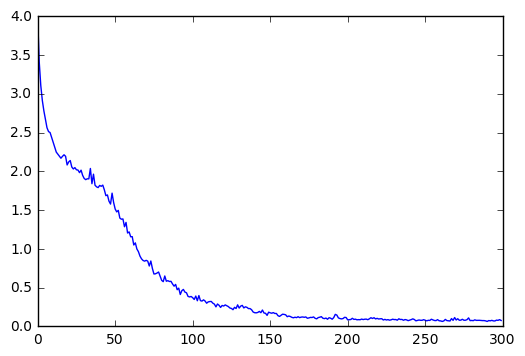

In [85]:
import matplotlib.pyplot as plt
plt.plot(trainLossVec)
plt.show()